# MPPI control of a Differential Drive Robot

/home/tigerwife/Documents/EE_7500_project/python_simple_mppi/scripts/utils.py:46: SyntaxWarning: invalid escape sequence '\o'
  ax2.plot(t_steps,wb_arr, 'r-', label='$\omega_b$', linewidth=2)
/home/tigerwife/Documents/EE_7500_project/python_simple_mppi/scripts/utils.py:49: SyntaxWarning: invalid escape sequence '\o'
  ax2.set_title('u(1): Angular velocity $\omega_b$')


[INFO] delta_t : 0.10[s] , sim_steps : 10000[steps], total_sim_time : 1000.00[s]
Step : 0 time: --> 2.893610558986664 s, odometry: - [0.00198648 0.         0.00501045].
Step : 1 time: --> 0.24630230700969696 s, odometry: - [1.03804715e-02 4.20580342e-05 8.63032850e-03].
Step : 2 time: --> 0.24799040900170802 s, odometry: - [0.02257185 0.00014728 0.01162047].
Step : 3 time: --> 0.24624938099086285 s, odometry: - [0.03999861 0.00034979 0.01609994].
Step : 4 time: --> 0.24615395699441434 s, odometry: - [0.06222887 0.00070773 0.01815297].
Step : 5 time: --> 0.25793380799889565 s, odometry: - [0.08659165 0.00115003 0.02305414].
Step : 6 time: --> 0.24249894699454308 s, odometry: - [0.11904963 0.00189846 0.02752698].
Step : 7 time: --> 0.2446046340018511 s, odometry: - [0.15282231 0.00282835 0.03557165].
Step : 8 time: --> 0.24625248900055885 s, odometry: - [0.18933527 0.00412773 0.04668611].
Step : 9 time: --> 0.24499341599643232 s, odometry: - [0.23134369 0.00609036 0.05408888].
Step : 10 

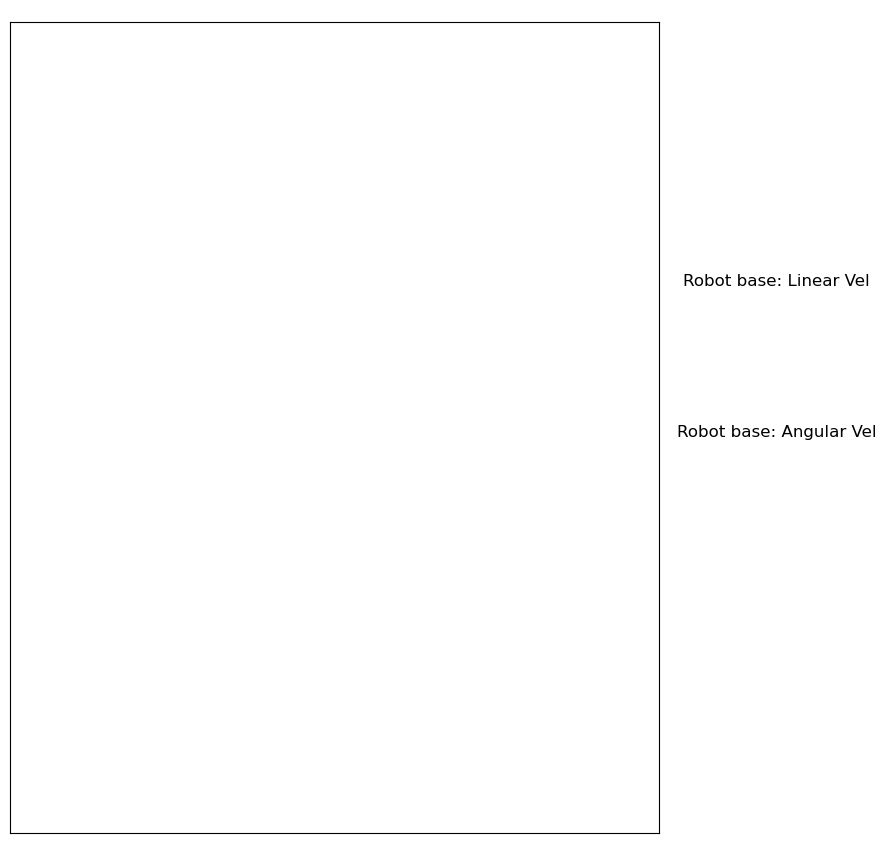

In [1]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt
from scripts.diffdrive import DiffDriveVehicle
from scripts.animation import Animator
from scripts.mppi import MPPIControllerDiffDrive
from scripts.utils import curr_time, debug_lock, plot_ref_vs_tracked_path, compute_erros, results_inputs

# Setup simulation parameters
# OBSTACLE_CIRCLES = np.array([+20.0,+20.0,1.0])
# Obstacles are deifned in the global/inertial coordinate frame

TRACK_TYPE = "oval_path" # "oval", "figure_eight"
show_animation = False # Default true
save_animation = False # Default False
delta_t = 0.1 # [sec]
sim_steps = 10000 # [steps]
num_samples = 100 # [int]
horizon_ = 20 # [int]
print(f"[INFO] delta_t : {delta_t:.2f}[s] , sim_steps : {sim_steps}[steps], total_sim_time : {delta_t*sim_steps:.2f}[s]")
actual_steps = 0

# Load and visualize reference path
if (TRACK_TYPE == "oval_path"):
    ref_path = np.genfromtxt('./data/ovalpath_diff.csv', delimiter=',', skip_header=1)
    
    OBSTACLE_CIRCLES = np.array([
    [+ 10.0, +5.0, 4.0], # pos_x, pos_y, radius [m] in the global frame
    [+10.0, 33.0, 2.0], 
    ])

elif (TRACK_TYPE == "figure_eight"):
    ref_path = np.genfromtxt('./data/figure_eight.csv', delimiter=',', skip_header=1)

    OBSTACLE_CIRCLES = np.array([
    [+ 25.0, +30.0, 1.0], # pos_x, pos_y, radius [m] in the global frame
    [+25.0, 32.0, 1.0], 
])

else:
    raise ValueError(f"Requested path not available")

# Define vehicle type and MPPI
init_state = np.array([0, 0, 0.0]) # [x,y,theta]
vehicle = DiffDriveVehicle(delta_t=delta_t,
                           ref_path=ref_path[:, 0:2], # np.ndarray([])
                           abs_vb_val= 5.0, #[m/s]
                           abs_omega_val=1.5, # [rad/s]
                           obstacle_circles = OBSTACLE_CIRCLES,
                           init_state=init_state)

animator = Animator(vehicle_model=vehicle)
if TRACK_TYPE == "oval_path":
    aa = 80 # x,y weight
    bb = 1 # yaw weight
    cc = 80 # velocity weight
else:
    aa = 100.0 # x,y weight
    bb = 20.0 # yaw weight
    cc = 60.0 # velocity weight

dd1 = 0.01
dd2 = 0.01
cost_arr = np.array([aa, aa, bb, cc])
sigma_arr = np.array([[dd1, 0.0], [0.0, dd2]])

# Define MPPI object
# initialize a mppi controller for the vehicle
mppi = MPPIControllerDiffDrive(
    vehicle_model = vehicle,
    delta_t = delta_t*2.0, # [s]
    abs_vb_val = vehicle.abs_vb_val, # [m/s]
    abs_omega_val = vehicle.abs_omega_val, # [rad/s]
    ref_path = ref_path, # ndarray, size is <num_of_waypoints x 2>
    horizon_step_T = horizon_, # [steps]
    number_of_samples_K = num_samples, # [samples]
    param_exploration = 0.05,
    param_lambda = 50, # larger value of lambda heavily weighs low-cost path
    param_alpha = 0.98,
    sigma_matrix = sigma_arr,
    stage_cost_weight = cost_arr, # weight for [x, y, yaw, v]
    terminal_cost_weight = cost_arr, # weight for [x, y, yaw, v]
    obstacle_circles = OBSTACLE_CIRCLES, # [obs_x, obs_y, obs_radius]
    collision_safety_margin_rate = 1.2, # safety margin for collision check
)

# simulation loop
warm_up_step = -1
time_per_step = []
done_flag = False
tracked_path = [] # Odometry of robot
# Main loop
for i in range(sim_steps):
    # get current state of vehicle
    current_state = vehicle.get_state() # [x,y,yaw]
    tt = curr_time()
    # calculate input force with MPPI
    optim_u, optim_u_seq, optimal_traj, sampled_traj_list, done_flag = mppi.calc_control_input(observed_x = current_state)
    if (done_flag == False):
        tt2 = curr_time()
        tt_s = (tt2 - tt)/1000
        time_per_step.append(tt_s)
        # Give an initial velocity
        if i<=warm_up_step:
            optim_u = [1.0,0]
        vehicle.update(u=optim_u, x_t_prev= current_state, delta_t=delta_t, 
                    optimal_traj=optimal_traj[:, 0:2], 
                    sampled_traj_list=sampled_traj_list[:, :, 0:2])
        tracked_path.append(vehicle.state.copy())
        if show_animation:
            animator.draw_frame(vehicle.out_arr)
        print(f"Step : {i} time: --> {tt_s} s, odometry: - {vehicle.state.copy()}.")
        actual_steps+=1
    else:
        print(f"End of sequence")
        break
if show_animation:
    animator.show_animation(interval_ms=delta_t*1000) # show animation
if save_animation:
    animator.save_animation("result.mp4", interval=int(delta_t * 1000), movie_writer="ffmpeg")

# Generate Results

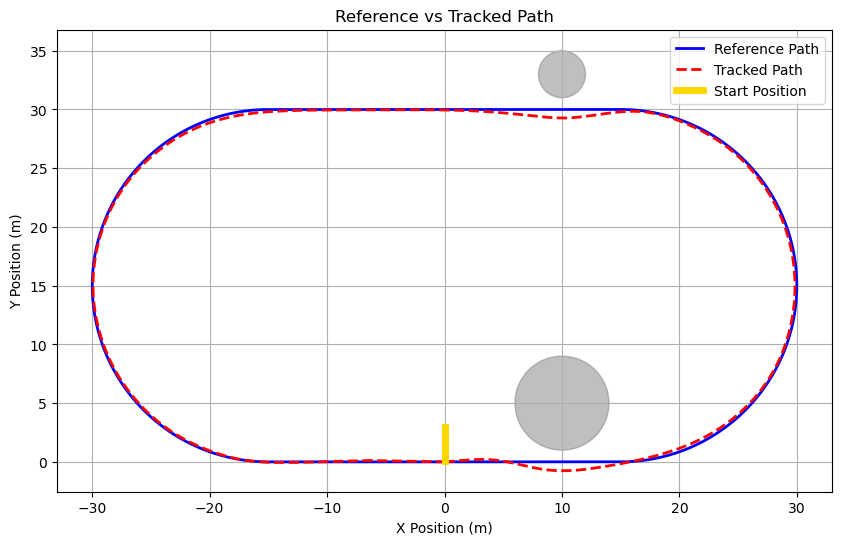

RMSE for X-position: 0.8477062060029542 m
RMSE for Y-position: 0.23995582893456105 m
RMSE for Yaw : 1.6873056717107384 degree
Mean linear velocity: 2.0217406300351564 m/s
Mean angular velocity: 0.08428036090387671 rad/s
Actual number of steps: 760 and total simulation time: 76.00 seconds
Average time per step: 0.236 ms


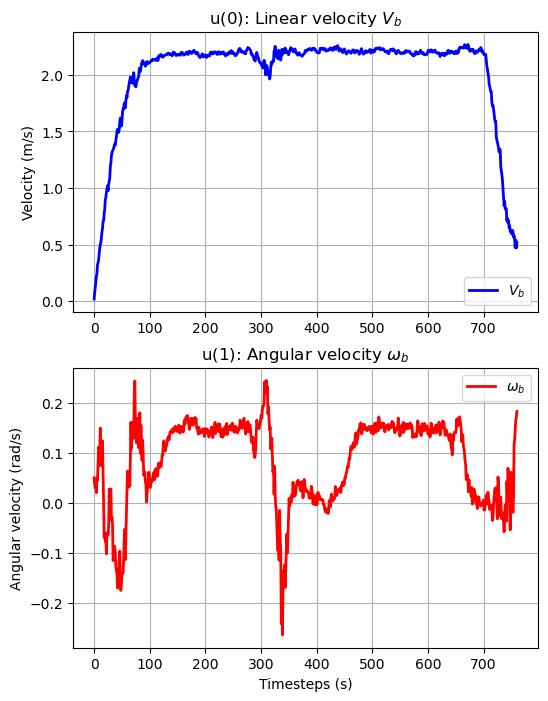

In [ ]:
# Reference path vs Tracked path
matched_path, matched_indicies = plot_ref_vs_tracked_path(ref_path=ref_path,
                                        tracked_path=tracked_path, 
                                        obstacle_arr=OBSTACLE_CIRCLES,
                                        save_plot=True)

# Compute RMSE errors
compute_erros(ref_path=ref_path, matched_path=matched_path)

# Average linear and angular velocities and their plots
results_inputs(u_optims=vehicle.u_history, matched_indices=matched_indicies, step_val=actual_steps)

# Computation steps
print(f"Actual number of steps: {actual_steps} and total simulation time: {actual_steps*delta_t:.2f} seconds")
print(f"Average time per step: {np.mean(time_per_step):0.3f} seconds")